# Assignment4
1. Data Gathering

Gather a dataset for humanoid robot v.s. person classification. For the robot images, you can sample frames from the videos below or you can scrap the from Google some others. For the person images, scrap them from Google.

- Something like 120 frames with robot and 120 frames for person is enough. 
- Do not use consecutive frames Label robot images as robot1.png, robot2.png,..., and the others as person1.png, ...
- Enlarge this dataset offline using spatial data augmention (e.g. mirror, flip, ...).
- Save these images with the following convention: robot1.png → robot1_aug1.png, robot1_aug2.png, ...
- Use some other augmentations (crops, color jitter, ...) in an online manner.
- Extra points:
    - Use CutMix as an online augmentation. See https://arxiv.org/pdf/1905.04899.pdf


2. Experiments:

Using your Robot v.s. Human dataset:

- Fine-tune VGG, ResNet and DenseNet for your custom dataset of humanoid robot classification (Binary classification Robot v.s. Human) and compare them.
- Compare the following: Fine-Tuned ResNet and ResNet as fixed feature extractor with an MLP classifiers
- Extra Point:
    - Train a ResNet feature extractor with an SVM classifier. You can use sklearn for the SVM. Compare this model to the Fine-Tuned Resnet and the Fixed-ResNet + MLP classifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as Functions
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time
import pandas as pd
import PIL
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
''' Move tensors to cuda/chosen device , dataloader to move data to chosen device'''
def move_to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [move_to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield move_to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/CUDA_vision/dataset'

In [ ]:
torch.manual_seed(43)

transform = transforms.Compose([transforms.Resize(300),
                                transforms.CenterCrop(224),
                                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

dataset = dsets.ImageFolder(data_path, transform=transform)

val_data_size = np.round(len(dataset)*0.25) #20% of the training set
train_data_size = len(dataset) - val_data_size

train_data, val_data = torch.utils.data.dataset.random_split(dataset, [int(train_data_size), int(val_data_size)])

print(f"Training set size: {len(train_data)} images")
print(f"Validation set size: {len(val_data)} images")

Training set size: 900 images
Validation set size: 300 images


In [ ]:
b = 32 # batch size

train_loader = torch.utils.data.DataLoader(train_data, batch_size=b, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=b*2, shuffle=True)

images, labels = next(iter(train_loader))

In [ ]:
device = get_default_device()

train_data_loader = DeviceDataLoader(train_loader, device)
val_data_loader = DeviceDataLoader(val_loader, device)

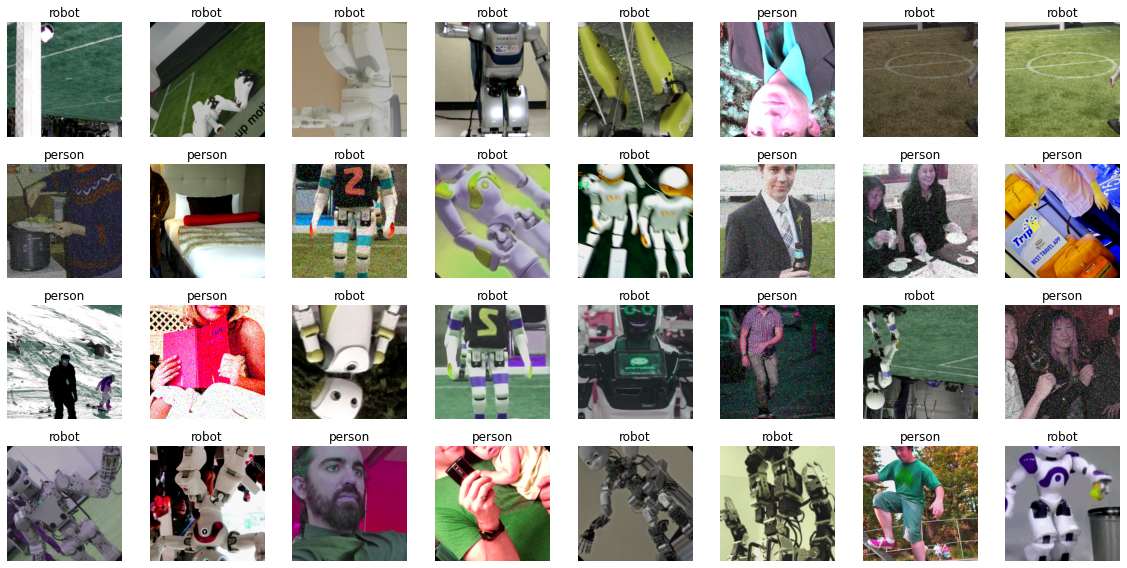

In [ ]:
#code taken from the class material

def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()
            
# Get a batch of training data and displaying it
class_names = dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

show_grid(inputs, titles=titles)

#Helpers

In [ ]:
class Helpers(object):
    def accuracy(self, target_label, predicted_label):

        _, prediction = torch.max(predicted_label, dim=1)
        acc = torch.sum(prediction == target_label).item() / len(prediction)
        return torch.tensor(acc)

    def confusion_matrix(self, model, test_data_loader):

        cm = np.zeros([2,2])
        with torch.no_grad():
            for images, labels in test_data_loader:
                predictions = model(images)
                maxPreds, preds = torch.max(predictions, dim=1)
                for idx, label in enumerate(labels):
                    cm[label.item(), preds[idx].item()] += 1 
        return cm

In [ ]:
class Train_model():
    def __init__(self,
                 model,
                 loss_function,
                 optimizer,
                 scheduler,
                 val_data_loader,
                 train_data_loader,
                 epochs=10):
        
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.val_data_loader = val_data_loader
        self.train_data_loader = train_data_loader
        self.epochs = epochs

    def train(self, input_image, target_label):

        self.model.train()

        self.optimizer.zero_grad()
        output = self.model(input_image)
        loss = self.loss_function(output, target_label)
        loss.backward()
        self.optimizer.step()
        train_acc = Helpers().accuracy(target_label, output)

        return loss.item(), train_acc

    def evaluate(self, data_loader):

        val_loss = []
        val_accu = []

        self.model.eval()
        with torch.no_grad():
            for image, label in data_loader:
                output = self.model(image)
                val_loss.append(self.loss_function(output, label))
                val_accu.append(Helpers().accuracy(label, output))

        val_loss = torch.stack(val_loss).mean()
        val_accu = torch.stack(val_accu).mean()

        return val_loss.item(), val_accu.item()

    def model_fit(self):

        val_loss = []
        val_accu = []
        train_loss = []
        train_accu = []

        epochs = []

        print(f"Training started")
        print(f"\n")

        for i in range(self.epochs):
            train_loss_iter = []
            train_accu_iter = []
            for image, label in self.train_data_loader:
                loss, accu = self.train(image, label)
                train_loss_iter.append(loss)
                train_accu_iter.append(accu)

            v_loss, v_accu = self.evaluate(self.val_data_loader)
            val_loss.append(v_loss)
            val_accu.append(v_accu)
            epochs.append(i)

            self.scheduler.step()
            train_loss.append(np.mean(train_loss_iter))
            train_accu.append(np.mean(train_accu_iter))

            if i % 5 == 0 or i == self.epochs-1:
                print(f"Epoch {i+1}/{self.epochs}:")
                print(f"    Train loss: {np.round(np.mean(train_loss_iter), 2)}")
                print(f"    Train accuracy: {np.round(np.mean(train_accu_iter), 2)*100}%")
                print(f"    Val loss: {np.round(v_loss, 2)}")
                print(f"    Val accuracy: {np.round(v_accu, 2)*100}%")
                print(f"\n")

        print(f"Training completed!")

        return epochs, train_loss, train_accu, val_loss, val_accu

In [ ]:
#code usesd from the lecture
import os
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

#VGG

In [ ]:
set_random_seed()

In [ ]:
vgg = torchvision.models.vgg19(pretrained=True)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
num_nuerons = vgg.classifier
vgg.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Training started


Epoch 1/20:
    Train loss: 0.74
    Train accuracy: 51.99999809265137%
    Val loss: 0.7
    Val accuracy: 49.0%


Epoch 6/20:
    Train loss: 0.46
    Train accuracy: 77.99999713897705%
    Val loss: 0.41
    Val accuracy: 84.0%


Epoch 11/20:
    Train loss: 0.32
    Train accuracy: 86.00000143051147%
    Val loss: 0.23
    Val accuracy: 87.0%


Epoch 16/20:
    Train loss: 0.11
    Train accuracy: 94.9999988079071%
    Val loss: 0.12
    Val accuracy: 94.0%


Epoch 20/20:
    Train loss: 0.06
    Train accuracy: 98.00000190734863%
    Val loss: 0.07
    Val accuracy: 97.0%


Training completed!


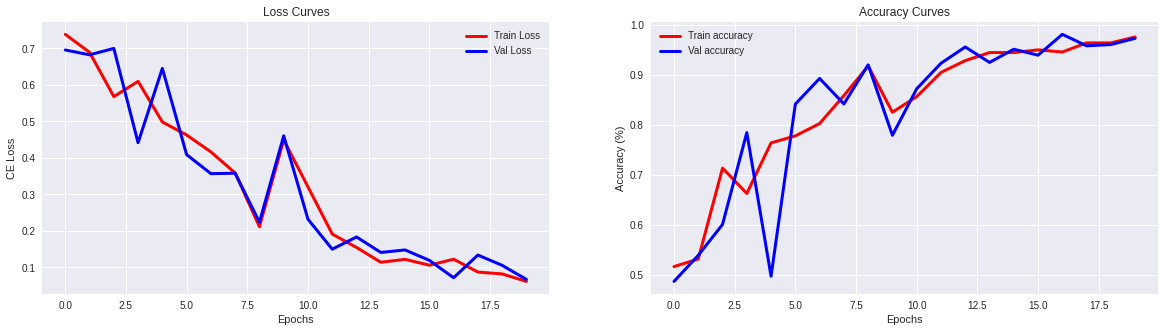

In [ ]:
model = move_to_device(vgg, device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
epoch = 20

model_fit = Train_model(model,
                        loss_function,
                        optimizer,
                        scheduler,
                        val_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)

ax[0].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[0].plot(epochs, val_loss, c="blue", label="Val Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Loss Curves")

ax[1].plot(epochs, train_accu, c="red", label="Train accuracy", linewidth=3)
ax[1].plot(epochs, val_accu, c="blue", label="Val accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Accuracy Curves")

plt.show()

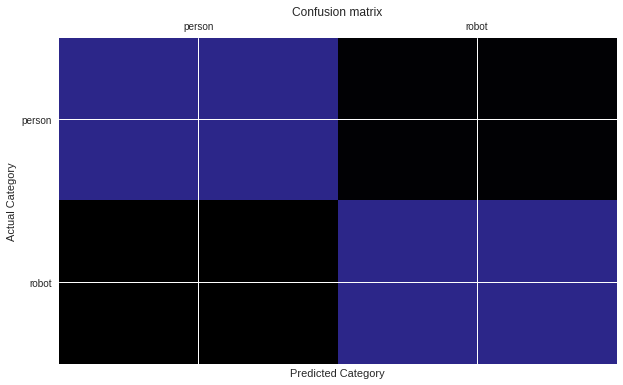

In [ ]:
cm = Helpers().confusion_matrix(model, val_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(2), dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(2), dataset.classes)
plt.show()

#ResNet

In [ ]:
set_random_seed()

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_nuerons = resnet.fc.in_features
resnet.fc = nn.Linear(num_nuerons, 2)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training started


Epoch 1/20:
    Train loss: 0.14
    Train accuracy: 93.99999976158142%
    Val loss: 0.18
    Val accuracy: 96.0%


Epoch 6/20:
    Train loss: 0.05
    Train accuracy: 98.00000190734863%
    Val loss: 0.06
    Val accuracy: 99.0%


Epoch 11/20:
    Train loss: 0.07
    Train accuracy: 99.00000095367432%
    Val loss: 0.04
    Val accuracy: 99.0%


Epoch 16/20:
    Train loss: 0.01
    Train accuracy: 100.0%
    Val loss: 0.02
    Val accuracy: 99.0%


Epoch 20/20:
    Train loss: 0.01
    Train accuracy: 100.0%
    Val loss: 0.02
    Val accuracy: 100.0%


Training completed!


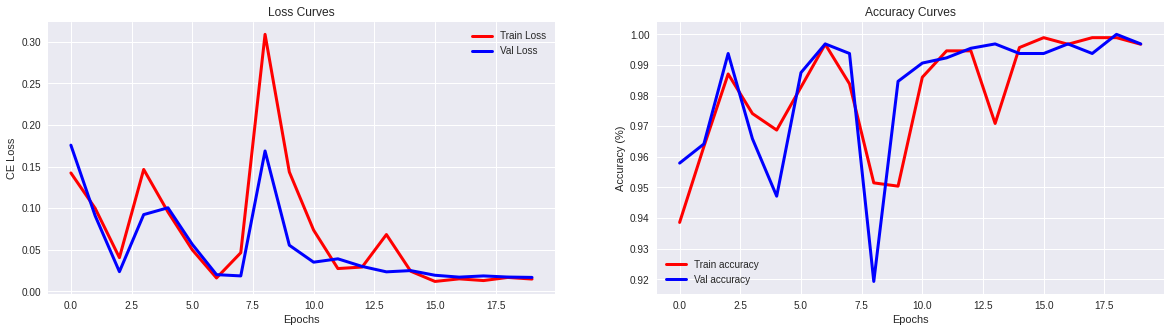

In [ ]:
model = move_to_device(resnet, device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
epoch = 20

model_fit = Train_model(model,
                        loss_function,
                        optimizer,
                        scheduler,
                        val_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)

ax[0].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[0].plot(epochs, val_loss, c="blue", label="Val Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Loss Curves")

ax[1].plot(epochs, train_accu, c="red", label="Train accuracy", linewidth=3)
ax[1].plot(epochs, val_accu, c="blue", label="Val accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Accuracy Curves")

plt.show()

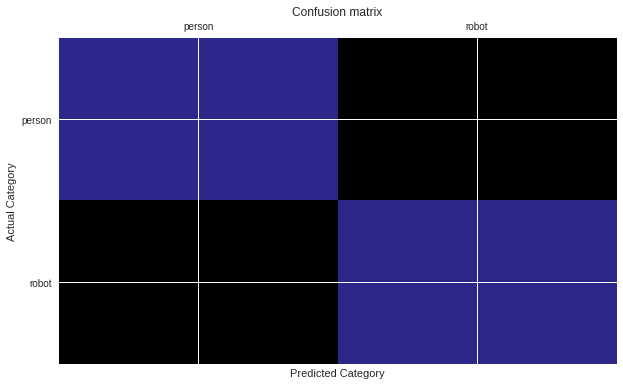

In [ ]:
cm = Helpers().confusion_matrix(model, val_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(2), dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(2), dataset.classes)
plt.show()

#DenseNet

In [ ]:
set_random_seed()

In [ ]:
densenet = torchvision.models.densenet201(pretrained=True)
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
num_nuerons = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_nuerons, 2)
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Training started


Epoch 1/20:
    Train loss: 0.16
    Train accuracy: 94.9999988079071%
    Val loss: 0.03
    Val accuracy: 99.0%


Epoch 6/20:
    Train loss: 0.02
    Train accuracy: 99.00000095367432%
    Val loss: 0.02
    Val accuracy: 99.0%


Epoch 11/20:
    Train loss: 0.02
    Train accuracy: 100.0%
    Val loss: 0.04
    Val accuracy: 100.0%


Epoch 16/20:
    Train loss: 0.02
    Train accuracy: 99.00000095367432%
    Val loss: 0.06
    Val accuracy: 99.0%


Epoch 20/20:
    Train loss: 0.01
    Train accuracy: 100.0%
    Val loss: 0.02
    Val accuracy: 99.0%


Training completed!


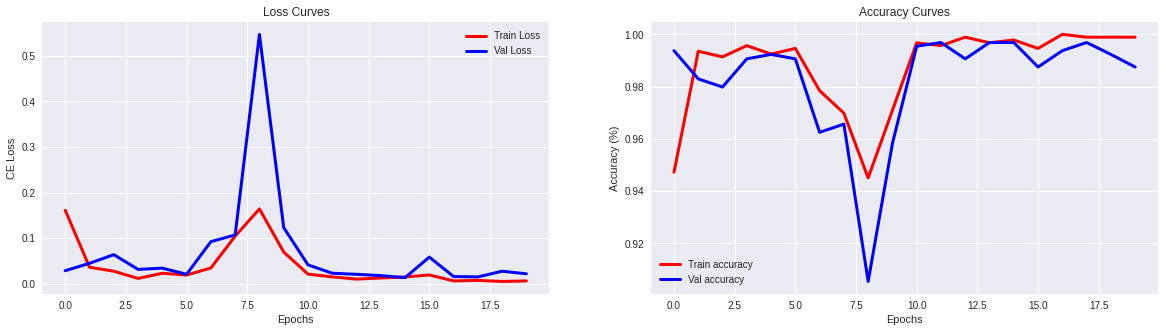

In [ ]:
model = move_to_device(densenet, device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
epoch = 20

model_fit = Train_model(model,
                        loss_function,
                        optimizer,
                        scheduler,
                        val_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)

ax[0].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[0].plot(epochs, val_loss, c="blue", label="Val Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Loss Curves")

ax[1].plot(epochs, train_accu, c="red", label="Train accuracy", linewidth=3)
ax[1].plot(epochs, val_accu, c="blue", label="Val accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Accuracy Curves")

plt.show()

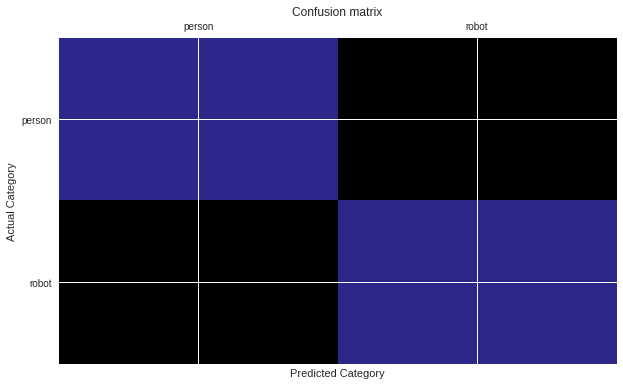

In [ ]:
cm = Helpers().confusion_matrix(model, val_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(2), dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(2), dataset.classes)
plt.show()

#Comparision of VGG, Resnet, DenseNet

- VGG
    - Validation accuracy = 97%
    - Validation loss = 0.06
    - Training loss = 0.07

- ResNet
    - Validation accuracy = 100%
    - Validation loss = 0.02
    - Training loss = 0.01

- DenseNet
    - Validation accuracy = 99%
    - Validation loss = 0.02
    - Training loss = 0.01

As seen from the above values, all three frameworks perform better on the custom data of robot vs human. Since ResNet uses just a Linear layer as classifier and the network is not so dense, the network appears to perfor with an accuracy of 100% on validation data. This might show that the model might be overfitting the data since the loss is too less and a validation accuracy of 100%.

On the other hand, the other two model performs better as well. In case of VGG net, it uses an MLP as a classification layer, and in the initial stages of the learning process, the network shows a weak performance but finally the model produces an optimal performance.

The flow of loss and the accuracy can be visualized in the loss curves and accuracy curves. Since its a two class classification or binary classification, the confusion matrix does not provide much information as the performance on classification is much higher.

#Resnet-MLP

In [ ]:
set_random_seed()

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_nuerons = resnet.fc.in_features
for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Sequential(
    nn.Linear(in_features=num_nuerons, out_features=256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=256, out_features=256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=256, out_features=2)
)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training started


Epoch 1/20:
    Train loss: 0.6
    Train accuracy: 68.00000071525574%
    Val loss: 0.41
    Val accuracy: 91.0%


Epoch 6/20:
    Train loss: 0.14
    Train accuracy: 93.99999976158142%
    Val loss: 0.05
    Val accuracy: 99.0%


Epoch 11/20:
    Train loss: 0.08
    Train accuracy: 97.00000286102295%
    Val loss: 0.04
    Val accuracy: 98.0%


Epoch 16/20:
    Train loss: 0.13
    Train accuracy: 94.9999988079071%
    Val loss: 0.04
    Val accuracy: 98.0%


Epoch 20/20:
    Train loss: 0.08
    Train accuracy: 98.00000190734863%
    Val loss: 0.04
    Val accuracy: 99.0%


Training completed!


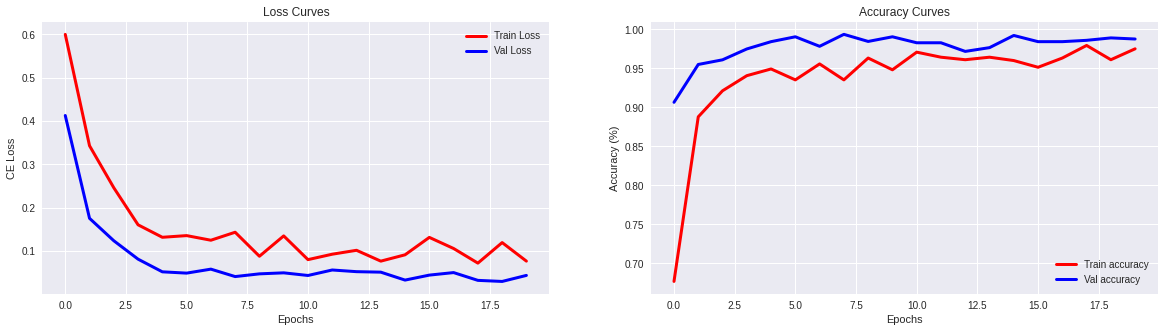

In [ ]:
model = move_to_device(resnet, device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
epoch = 20

model_fit = Train_model(model,
                        loss_function,
                        optimizer,
                        scheduler,
                        val_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)

ax[0].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[0].plot(epochs, val_loss, c="blue", label="Val Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Loss Curves")

ax[1].plot(epochs, train_accu, c="red", label="Train accuracy", linewidth=3)
ax[1].plot(epochs, val_accu, c="blue", label="Val accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Accuracy Curves")

plt.show()

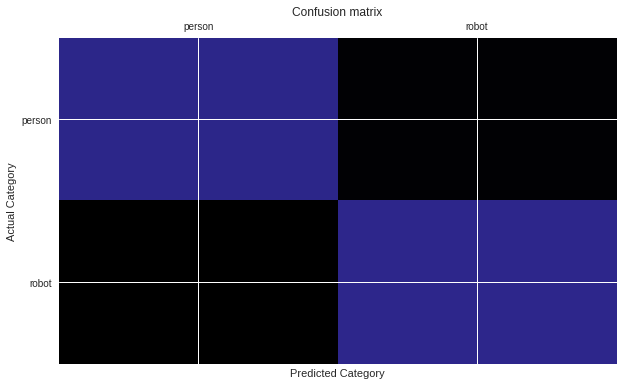

In [ ]:
cm = Helpers().confusion_matrix(model, val_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(2), dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(2), dataset.classes)
plt.show()

#Resnet-SVM

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/CUDA_vision/dataset'

In [ ]:
set_random_seed()

torch.manual_seed(43)

transform = transforms.Compose([transforms.Resize(300),
                                transforms.CenterCrop(224),
                                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

dataset = dsets.ImageFolder(data_path, transform=transform)

print(f"Dataset size: {len(dataset)} images")

Dataset size: 1200 images


In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet_model = move_to_device(resnet, device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
image_data = dataset.imgs

image_feature_vector = np.zeros((1200, 512))
image_name = []
image_label = []

for i, im_data in enumerate(image_data):

    image = PIL.Image.open(im_data[0])
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    
    image = move_to_device(image, device)

    feature = resnet_model(image)

    image_feature_vector[i, :] = feature.cpu().detach().numpy().reshape(512,)
    image_name.append(im_data[0])
    image_label.append(im_data[1])
    
print(image_feature_vector.shape)
print(np.shape(image_name))
print(np.shape(image_label))

(1200, 512)
(1200,)
(1200,)


In [ ]:
DF_dataset = pd.DataFrame(image_feature_vector)
DF_dataset['image'] = image_name
DF_dataset['label'] = image_label
DF_dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,image,label
0,0.920353,0.971188,0.885319,1.012081,1.030252,0.933737,0.880021,1.225751,0.960224,0.945014,0.919690,0.860988,0.818971,0.937574,0.942025,0.907765,0.815023,1.352443,0.961530,0.838579,0.917534,1.025360,0.930358,0.939047,0.944849,0.905296,0.984301,0.999059,0.850179,0.897604,0.966278,0.848579,0.873603,0.797805,0.873407,0.887191,0.978536,0.890394,0.845438,0.863313,...,0.887620,0.894515,0.895842,0.914901,0.854856,0.854536,0.877343,0.985955,0.805782,0.845831,1.042675,1.078691,1.005051,0.918971,1.097356,0.864325,0.964363,1.001485,0.969750,0.799491,0.803667,0.853393,0.842606,0.895200,0.925843,0.938214,0.985318,0.849446,1.034079,0.857768,0.951505,0.836538,1.126473,1.014239,0.992568,0.857742,1.121152,0.990158,/content/drive/MyDrive/Colab Notebooks/CUDA_vi...,0
1,0.874826,0.904757,0.938524,1.104901,0.908463,0.912473,0.883729,1.189305,0.910161,1.004258,0.971327,0.905120,0.970414,0.879947,0.872639,0.934930,0.884585,1.373431,0.962731,0.894388,0.852594,1.111269,0.961471,0.905835,0.913894,0.982407,1.015857,0.989278,0.949096,0.921219,0.870097,0.933367,0.928773,0.860017,0.853659,0.906222,0.897611,0.907794,0.838409,0.850269,...,0.920301,0.887051,0.877757,0.912353,0.910484,0.931513,0.908308,1.005046,0.922780,0.838862,1.173018,0.992121,0.943490,1.031670,1.143816,0.909759,0.964093,1.081225,0.949355,0.893296,0.946342,0.962117,0.886032,0.878719,0.865434,0.941216,0.989525,0.888673,0.936775,0.933660,0.905144,0.868414,1.115966,0.964294,0.920189,1.001097,1.152479,0.933235,/content/drive/MyDrive/Colab Notebooks/CUDA_vi...,0
2,0.864068,0.922728,0.826823,1.083650,0.948070,0.946575,0.927029,1.268075,0.936083,0.914245,0.869978,0.826593,0.869815,0.901468,0.949307,0.973136,0.870104,1.271665,0.950257,0.888273,0.842946,1.039933,0.928308,0.983627,0.891537,1.052524,0.983780,0.969274,0.869673,0.965920,0.963251,0.860013,0.906054,0.859311,0.862340,0.811774,1.000362,0.965649,0.843242,0.831028,...,0.965117,0.893704,0.923476,0.828696,0.963708,0.854736,0.915670,1.015038,0.895536,0.946690,1.145023,0.950774,0.979134,0.998751,1.109234,0.873953,0.994266,0.964831,0.961104,0.862520,0.846976,0.896325,0.872604,0.872298,1.006671,0.937244,0.884542,0.894015,0.899813,0.884138,0.903785,0.900584,1.082682,1.005516,0.929053,0.946858,1.136004,1.005676,/content/drive/MyDrive/Colab Notebooks/CUDA_vi...,0
3,0.908069,0.953295,0.861360,1.010808,0.833806,0.859950,0.898407,1.089582,0.906269,0.997469,0.913814,0.854146,0.898242,0.957850,0.914076,0.918076,0.940017,1.339910,0.945251,0.872424,0.936380,1.030960,0.893737,0.971022,0.906687,0.955051,0.972504,1.028392,0.873551,0.881537,0.927691,0.838945,0.948425,0.880176,0.851755,0.816728,0.965258,0.972592,0.842049,0.796638,...,0.839201,0.897602,0.854372,0.891294,0.868707,0.905589,0.969688,1.062523,0.838298,0.849524,1.038347,0.966302,0.948053,0.962993,1.069523,0.920422,0.936429,1.005136,0.966343,0.861826,0.877570,0.899221,0.896549,0.878145,0.972322,0.956899,0.957348,0.948333,0.897989,0.904747,0.902754,0.858524,1.149173,0.969536,0.845031,0.873636,1.090799,0.910746,/content/drive/MyDrive/Colab Notebooks/CUDA_vi...,0
4,0.859935,0.923275,0.843099,1.057155,0.933583,0.878861,0.866010,1.138232,0.906042,0.960589,0.909293,0.845386,0.959332,0.953092,0.976525,0.949313,0.912312,1.412843,0.964054,0.790535,0.961621,1.064924,0.877234,0.992159,0.960124,0.896423,1.041700,1.005774,0.889948,0.911228,0.878251,0.817416,0.828681,0.861536,0.872826,0.875298,0.930052,1.032505,0.917726,0.908074,...,0.976792,0.833316,0.881023,0.900093,0.806814,0.956935,0.897629,1.047612,0.882192,0.830298,1.048525,1.018441,0.941973,0.950964,1.035157,0.836998,1.001615,0.990255,0.931264,0.938096,0.813302,0.913803,0.924227,0.857309,0.926252,0.791310,0.852350,0.855525,0.907150,0.873139,0.935444,0.870610,1.155086,0.938889,0.915143,

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
X = DF_dataset.drop(['image', 'label'], axis=1)
y = DF_dataset.label
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

In [ ]:
svm_classifier = SVC()
svm_classifier.fit(Xtrain, ytrain)
preds = svm_classifier.predict(Xtest)

Accuracy on classification: 76.25%


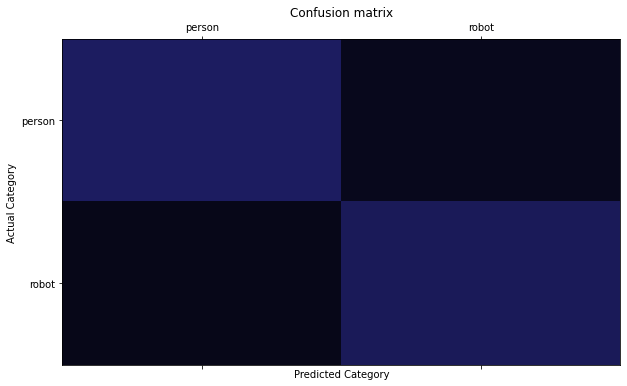

In [ ]:
print(f"Accuracy on classification: {accuracy_score(ytest, preds)*100}%")
cm = confusion_matrix(ytest, preds)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(2), dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(2), dataset.classes)
plt.show()

#comparision

- Fine Tuned ResNet
    - Train accuracy: 100.0%
    - Val loss: 0.02
    - Val accuracy: 100.0%
    - Train loss: 0.01


- ResNet with MLP classifier
    - Train loss: 0.08
    - Train accuracy: 98.00000190734863%
    - Val loss: 0.04
    - Val accuracy: 99.0%

The perfomance of both the model looks interestingly higher. But the performance of the  model with MLP classifier shows a slight lower performance but the numbers does not look like the model is overfitting.

Similarly the confusion matrix does not provide much distinguishable visualization due to the higher validation accuracy.

Model with SVM classifier shows a moderate performance of a validation accuracy of 76%. This might be due to the processing of the input dataset. But, since the feature from the image data are too large, SVM fails to handle the featrues and shows a moderate performance